# ch05.08. 기초모델 구현 - Softmax Regression
---
* 날짜: 2022.05.18
* 이름: 윤태우

## 학습내용
    - 소프트맥스 회귀 프로세스를 이해한다.
    - 소프트맥스 함수를 구현한다.

```
import numpy as np
import matplotlib.pyplot as plt
```

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

$$p_i = e^{zi} / Σ^k_{j=1}e^{zi}$$

k = 차원 zi는 i번째 성분


$$-Σ[yⁱ * {logyʰ} + (1-yⁱ) * log(1-yʰ)]$$

yⁱ = y1, 1-yⁱ = y2, yʰ = p1, 1-yʰ = p2 라고하면,

$$-Σ[y1 * log(p1) + y2 * log(p2)]$$

이는 결국 $$-Σᵢᵏ[yⁱ * log(pⁱ)]$$

## 클래스 작성
---

In [ ]:
class SoftmaxRegressionGD():
  def __init__(self, lr=0.001, random_state=1):
    self.lr=lr
    self.seed = np.random.RandomState(random_state)
  
  def init_weights(self, X):
    size = X.shape[1]
    y_size = 3 # 원하는 결과값 벡터의 차원 수를 여기에 입력해주면 됨
    self.w = self.seed.normal(0,0.01, size = (size+1, y_size)) # 원하는 결과의 피쳐 수만큼 형태를 만들어 주기위해 w를 X.shape[1] x y.shape[1]로 설정

# 소프트맥스 회귀로 얻고 싶은 클래스의 개수가 k개라면 우선 linear regression을 통해 인풋 벡터의 차원 수를 k로 변형시켜줘야함.
# 이는 가중치 w의 사이즈를 조절해서 변형 가능.

#linear regression
  def linear(self, X):
    return np.dot(X, self.w[:-1]) + self.w[-1] # w값들과 X의 내적 + bias의 값
  
  def softmax(self, X) :
    lin_X = self.linear(X)
    for i in range(X.shape[0]) :
      lin_X[i] = np.exp(lin_X[i])/np.sum(np.exp(lin_X[i])) 
    return lin_X
  
  def accuracy(self, X,y) :
    y_hat = self.softmax(X)
    y_logit = np.argmax(y_hat, axis = 1)
    acc = np.count_nonzero(np.argmax(y, axis = 1)==y_logit)/len(y)
    return acc

  def loss(self, y, y_hat) :
    return -np.log(y_hat[np.arange(len(y_hat)), np.argmax(y_hat, axis=1)]).sum() / len(y)
    # y_hat의 인덱스 [  [0 ~ y_hat의 길이], y_hat 최댓값의 위치]
  def evaluate(self, X, y):
    y_hat = self.softmax(X)
    loss = self.loss(y,y_hat)  # loss
    acc = self.accuracy(X,y)
    return loss, acc

# 최적화
  def fit(self,X,y, epochs=10, show_params=False):
    self.init_weights(X) # 가중치 초기화
    self.history=dict(loss=[], acc=[]) # history 초기화 

    for epoch in range(epochs) :
      y_hat = self.softmax(X)             # X의 i행은 i번째 샘플, j열은 i행의 j번째 성분의 확률. X.T와 예측값-정답값을 내적 (w의 사이즈는 (X.shape[1], y.shape[1]))
      self.w[:-1] -= np.dot(X.T, y_hat-y)*self.lr/ len(X)         # i번재 성분 zi의 순간 변화율. 즉 L(loss)의 zi에 대한 미분 (zi = softmax한 X의 i번째 성분)
      self.w[-1] -= np.sum(y_hat-y)*self.lr/ len(X)

      # 평가 및 결과 저장
      loss = self.evaluate(X, y)
      acc= self.accuracy(X,y)
      self.history['loss'].append(loss)         # key값만 지정되어 있는 딕셔너리 history에 각각 key값에 value들을 넣어준다.
      self.history['acc'].append(acc)         # key값만 지정되어 있는 딕셔너리 history에 각각 key값에 value들을 넣어준다.

         # epoch (최적화 시행횟수)에 따라 변하는 loss, acc(정확도)를 출력해준다.
      if show_params: print(self.w)
      if epoch % 100 == 0:
        print(f'[Epoch {epoch}] loss: {np.round(loss,2)}')
    

     # 데이터 흐름 시각화
  def draw_dflow(self, X, y, title='', figsize=(8,4)):
    y_hat = self.softmax(X) 
    y_pred = np.argmax(y_hat, axis=1)  # 예측값 y_hat이 최대일때의 위치
    y = np.argmax(y, axis=1)           # 정답 y가 최대일때의 위치
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.plot(y, label='y', marker = 'o', alpha = .5)
    plt.plot(y_pred, label='y_pred', marker = 'o', alpha = .5)
    plt.legend()
    plt.show()

  # 학습 곡선 시각화
  def draw_lcurve(self, title='', figsize=(8,4)):
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.plot(self.history['loss'], label='loss', marker='o')
    plt.plot(self.history['acc'], label='acc', marker='o')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [ ]:
# sum(loss)/len(loss)는 loss들의 평균이다. 따라서 L 의 식에서 1/n과 sigma 1~n 이 부분은 평균을 구하는 것이다.
# linear regression 에서 loss는 회귀선과 예측값이 얼마나 떨어져 있는가임. 따라서 좌표평면의 두 점 사이의 거리를 구하면 그 차이가 나옴.
# (x1,y1), (x2,y2) 두 점사이 거리  :( (x1-x2)**2 + (y1-y2)**2 )**(1/2)  -> 회귀선위의 x값과 예측값의 x는 같을 것이므로 결국 ((y1-y2)**2)**(1/2)이 된다.
# 로지스틱 회귀의 로스를 구하는 식에서 변형하면 소프트맥스의 로스를 구하는 식임.
# 로지스틱 회귀의 로스에서 log를 쓰는 이유는 log1 = 0이기 때문. y_hat 값이 1이면 로스 값은 0이 나옴. 반대로 예측값이 0, 실제값이 1이 나와버리면 loss 값이 무한대로 수렴해버린다.
# 로지스틱 회귀에서 yi = y1, 1-yi = y2, y_hat = p1, 1-y_hat = p2 라고 하면 y1log(p1)+y2log(p2) 즉, sigma yi*log(pi)

## iris 데이터로 분류 진행
---

### **데이터 로드**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
  
def mpg_loader(test_size=0.2, rs=1):
  df = sns.load_dataset('mpg')
  print('===== 데이터 확인 ====')
  print('* shape: ',df.shape)
  print(df.head())

  print('===== 범주 자료 제거 ====')
  df = df.drop(['origin', 'name'], axis=1)
  print('* shape: ',df.shape)

  print('===== 결측치 제거 ====')
  df = df.dropna(axis=0)
  print('* shape: ',df.shape)

  print('===== 정규화 ====')
  df=df.apply(lambda x: (x-x.mean())/ x.std(), axis=0)
  print(df.head())

  print('===== 넘파이 변환 ====')
  ds = df.to_numpy()
  X, y = ds[:, 1:], ds[:, 0]
  print(X.shape, y.shape)

  print('===== 데이터 분할 ====')

  X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=rs)
  print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
  return X_train, X_test, y_train, y_test



from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

def iris_loader(n_class, test_size=0.2, rs=1):
  iris = load_iris()
  X = iris.data
  y = iris.target
  print(X.shape, y.shape, X[0], y[0])
  
  if n_class==2:
    X = X[y!=2]
    y = y[y!=2]
    y = np.where(y==1, 1, 0)
  if n_class==3:
    ohe = OneHotEncoder(sparse=False)
    y = ohe.fit_transform(np.expand_dims(y,1))
  
  X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=rs)
   
  print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
  return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = iris_loader(3)

(150, 4) (150,) [5.1 3.5 1.4 0.2] 0
(112, 4) (38, 4) (112, 3) (38, 3)


### **학습전 성능 평가**

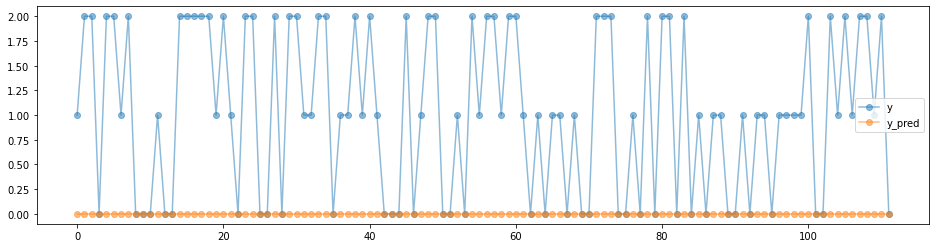

성능: (0.979699225186024, 0.33035714285714285)


In [ ]:
model = SoftmaxRegressionGD(lr=0.1)

model.init_weights(X_train)
model.draw_dflow(X_train, y_train, figsize=(16,4))
print(f'성능: {model.evaluate(X_train, y_train)}')

In [ ]:
model.fit(X_train, y_train, epochs=501)

[Epoch 0] loss: [0.58 0.37]
[Epoch 100] loss: [0.25 0.71]
[Epoch 200] loss: [0.24 0.97]
[Epoch 300] loss: [0.2  0.97]
[Epoch 400] loss: [0.17 0.97]
[Epoch 500] loss: [0.15 0.97]


### **학습**

### **학습 후 성능평가**

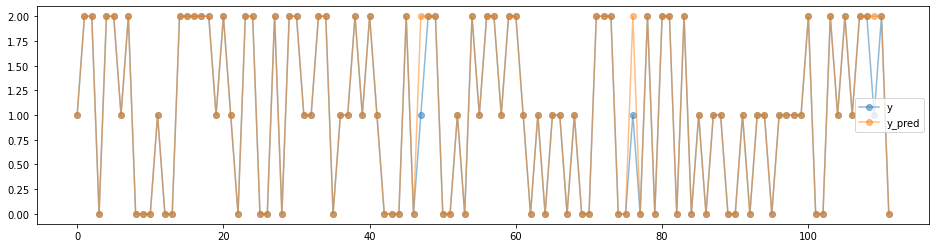

성능:  (0.15165628996228442, 0.9732142857142857)


In [ ]:
model.draw_dflow(X_train, y_train, figsize=(16,4))
print('성능: ', model.evaluate(X_train, y_train))

### **테스트셋 성능평가**

성능:  (0.20434787085011474, 0.9473684210526315)


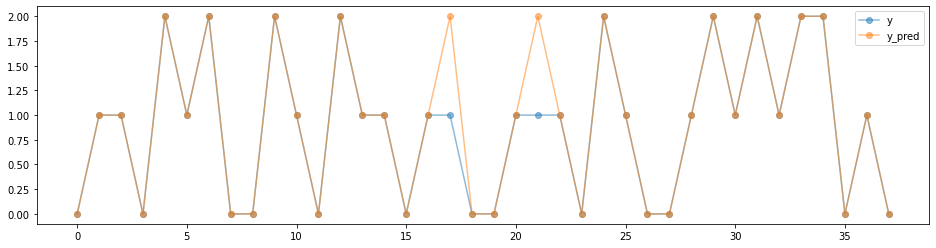

In [ ]:
print('성능: ', model.evaluate(X_test, y_test))
model.draw_dflow(X_test, y_test, figsize=(16,4))

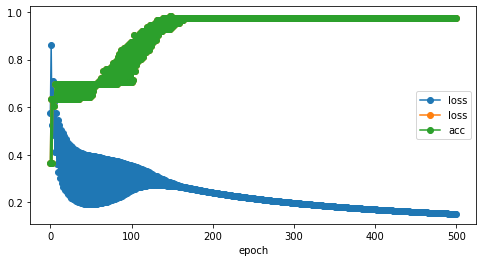

In [ ]:
model.draw_lcurve()